In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import scipy.stats as sps



In [2]:
#load data
rf1_train = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/rf1_training.csv')#includes ncvz google df & tois in rf2
rf2_train = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/rf2_training.csv')#includes ncvz google df & tois in rf2
rf3_train = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/rf3_training.csv') #includes ncvz google df & tois in rf2
rf_results = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/test-6/RF123_results_df_v6.csv')
rf_accs = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/test-6/RF123_accuracy_df_v6.csv')
mqdata = pd.read_csv('mcquillan_sample.csv')
cut1 = (rf_results['RF1predict_class']==1.0)
cut2 = (rf_results['RF2predict_class']==1.0)
cut3 = (rf_results['RF3predict_class']==3.0)
rf_passed = rf_results[cut1 & cut2 & cut3]

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Unvetted plot

In [3]:
# determine kde peaks to identify systematics

def kde(v, xlim):
    kernel = sps.gaussian_kde(v)
    kernel.set_bandwidth(bw_method=kernel.factor / 10.)
    xs = np.linspace(xlim[0], xlim[1], 1000)
    return xs, kernel(xs)

#run kde
x_orig = rf_results['Teff'].to_numpy()
y_orig = rf_results['ls-1'].to_numpy()
kde_x, kde_y = kde(np.log10(y_orig), (np.log10(.1),np.log10(70)))

# Array of peak indices
peaks = np.array([i for i in range(1, len(kde_y)-1) if kde_y[i-1] <
                  kde_y[i] and kde_y[i+1] < kde_y[i]])

# extract peak values
x_peaks = kde_x[peaks]
y_peaks = kde_y[peaks]

# isolate main peaks of systematics
peaks = np.sort(10**(x_peaks[x_peaks>.001])) #set a threshold for peaks
goodpeaks_1 = np.concatenate((peaks[6:14],[peaks[-1]])) #add in main peaks cut by threshold
goodpeaks = np.concatenate(([10**x_peaks[18]], goodpeaks_1)) #add in main peaks cut by threshold
print('There are systematic trends at:',goodpeaks, 'days')

There are systematic trends at: [ 0.9991462   2.34348414  2.87176134  3.61265471  4.88463334  5.79266703
  6.56129462  9.91768102 12.80796198 25.83510614] days


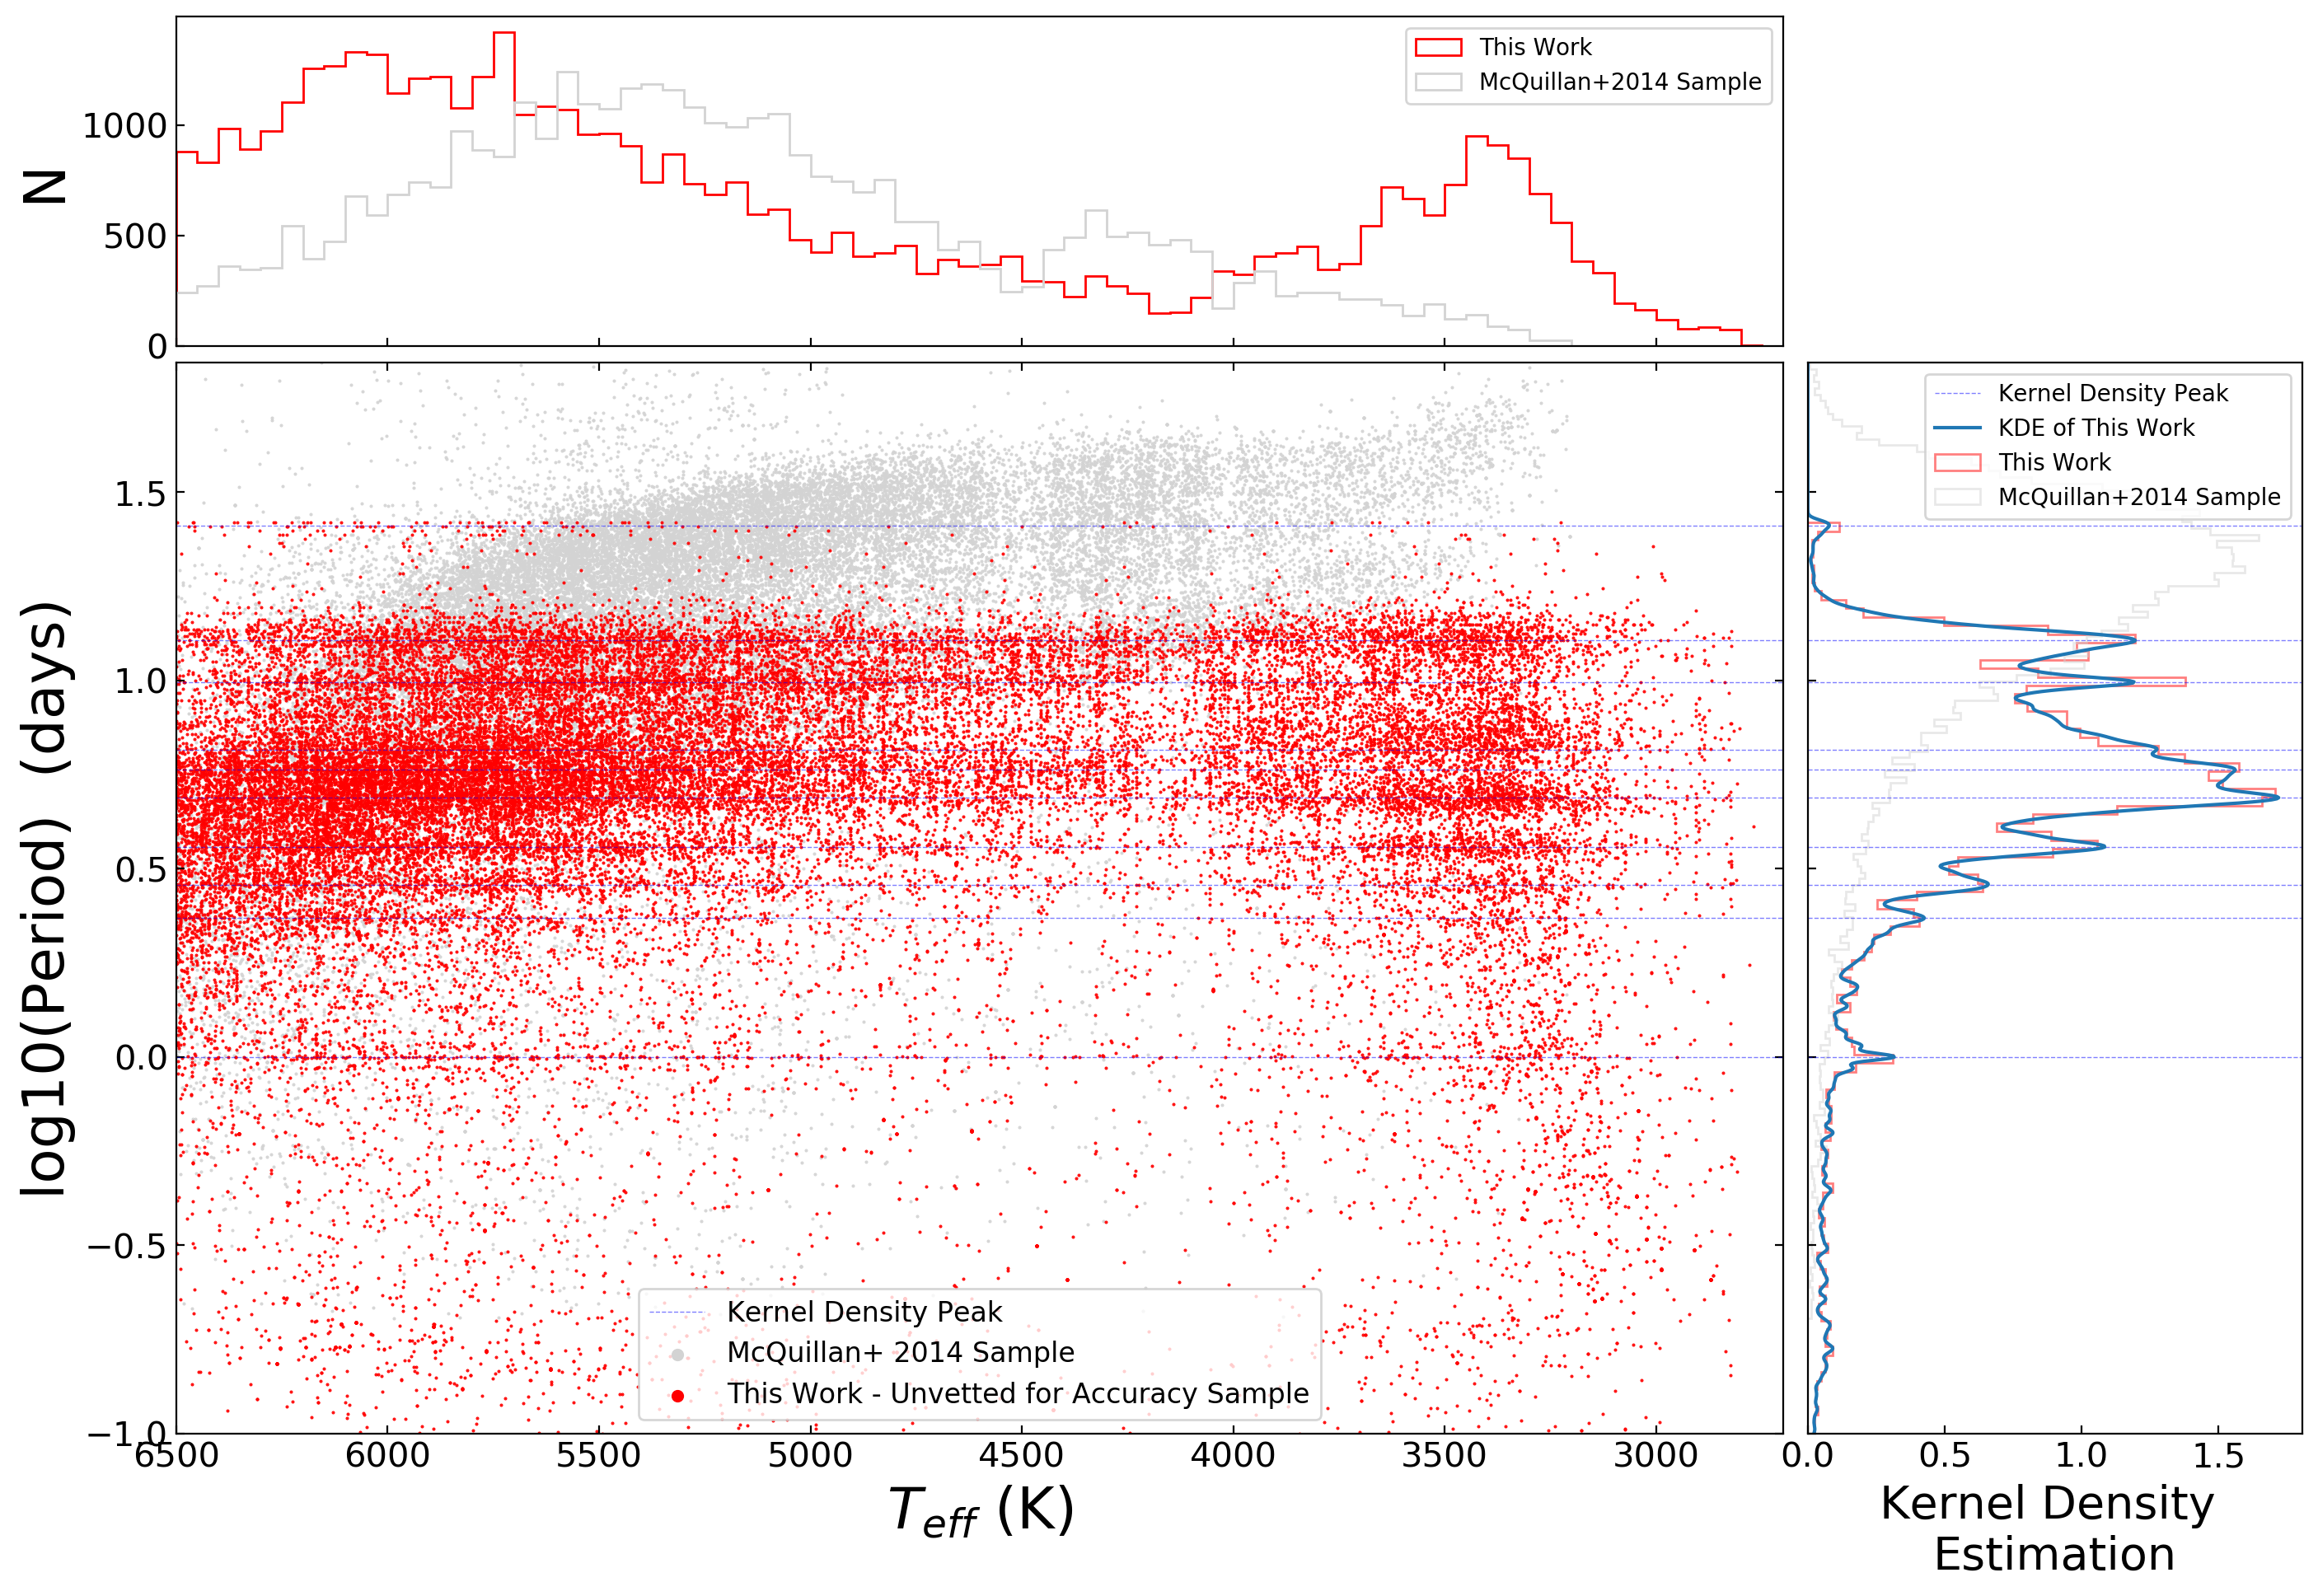

In [4]:
#final unvetted plot with systematics

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01 
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
# start with a rectangular Figure & define subplots using axes definitions
plt.figure(figsize=(15, 10),dpi=200)
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True, labelsize=15)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False, labelsize=15)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False, labelsize=15)

#plot kde main peaks on scatter plot and side plot
for i in goodpeaks:
    if i == goodpeaks[0]:
        ax_scatter.axhline(np.log10(i), linestyle='--',linewidth=.5,color='b',alpha=.5,label='Kernel Density Peak')
        ax_histy.axhline(np.log10(i), linestyle='--',color='b',alpha=.5,linewidth=.5, label ='Kernel Density Peak')
    else:
        ax_scatter.axhline(np.log10(i), linestyle='--',linewidth=.5,color='b',alpha=.5)
        ax_histy.axhline(np.log10(i), linestyle='--',color='b',alpha=.5,linewidth=.5)

# the scatter plot:
ax_scatter.scatter(mqdata['TEMP'],np.log10(mqdata['ROTATION_PERIOD'].to_numpy()),color='lightgrey',s=.2,rasterized=True,label='McQuillan+ 2014 Sample')
ax_scatter.scatter(x_orig, np.log10(y_orig),s=.2, color='r',rasterized=True, label='This Work - Unvetted for Accuracy Sample')
ax_scatter.set_xlabel('$T_{eff}$ (K)',fontsize=25)
ax_scatter.set_ylabel('log10(Period)  (days)',fontsize=25)
ax_scatter.set_xlim(6500, 2700)
ax_scatter.set_ylim(np.log10(.1),np.log10(70));
ax_scatter.legend(fontsize='large', markerscale=10)

# top histogram
binwidth = 0.25
xbins = np.arange(2700, 6500 + binwidth, 50)
ax_histx.hist(x_orig, bins=xbins, histtype='step',color='r',label='This Work')
ax_histx.hist(mqdata['TEMP'], bins=xbins, histtype='step',color='lightgrey',label='McQuillan+2014 Sample')
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histx.set_ylabel('N',fontsize=25)
ax_histx.legend()

#side plot histograms
ax_histy.hist(np.log10(y_orig),bins=150, histtype='step',orientation='horizontal',color='r',density=True, alpha=.5, label='This Work')
ax_histy.hist(np.log10(mqdata['ROTATION_PERIOD'].to_numpy()),bins=150, histtype='step',orientation='horizontal',color='lightgrey',density=True, alpha=.5,label='McQuillan+2014 Sample')
ax_histy.set_ylim(np.log10(.1),np.log10(70));
#side plot kde
kde_x, kde_y = kde(np.log10(y_orig), (np.log10(.1),np.log10(70)))
ax_histy.plot(kde_y, kde_x,label='KDE of This Work');
ax_histy.set_xlabel('Kernel Density \nEstimation',fontsize=20)
ax_histy.legend()


# plt.savefig('/Volumes/Seagate-stars/Final_Run/Plots/unvetted_periodteff.png')

# Vetted Results

In [5]:
y = rf_passed['ls-1'].to_numpy()
x = rf_passed['Teff'].to_numpy()
amps = rf_passed['lsamp-1'].to_numpy()



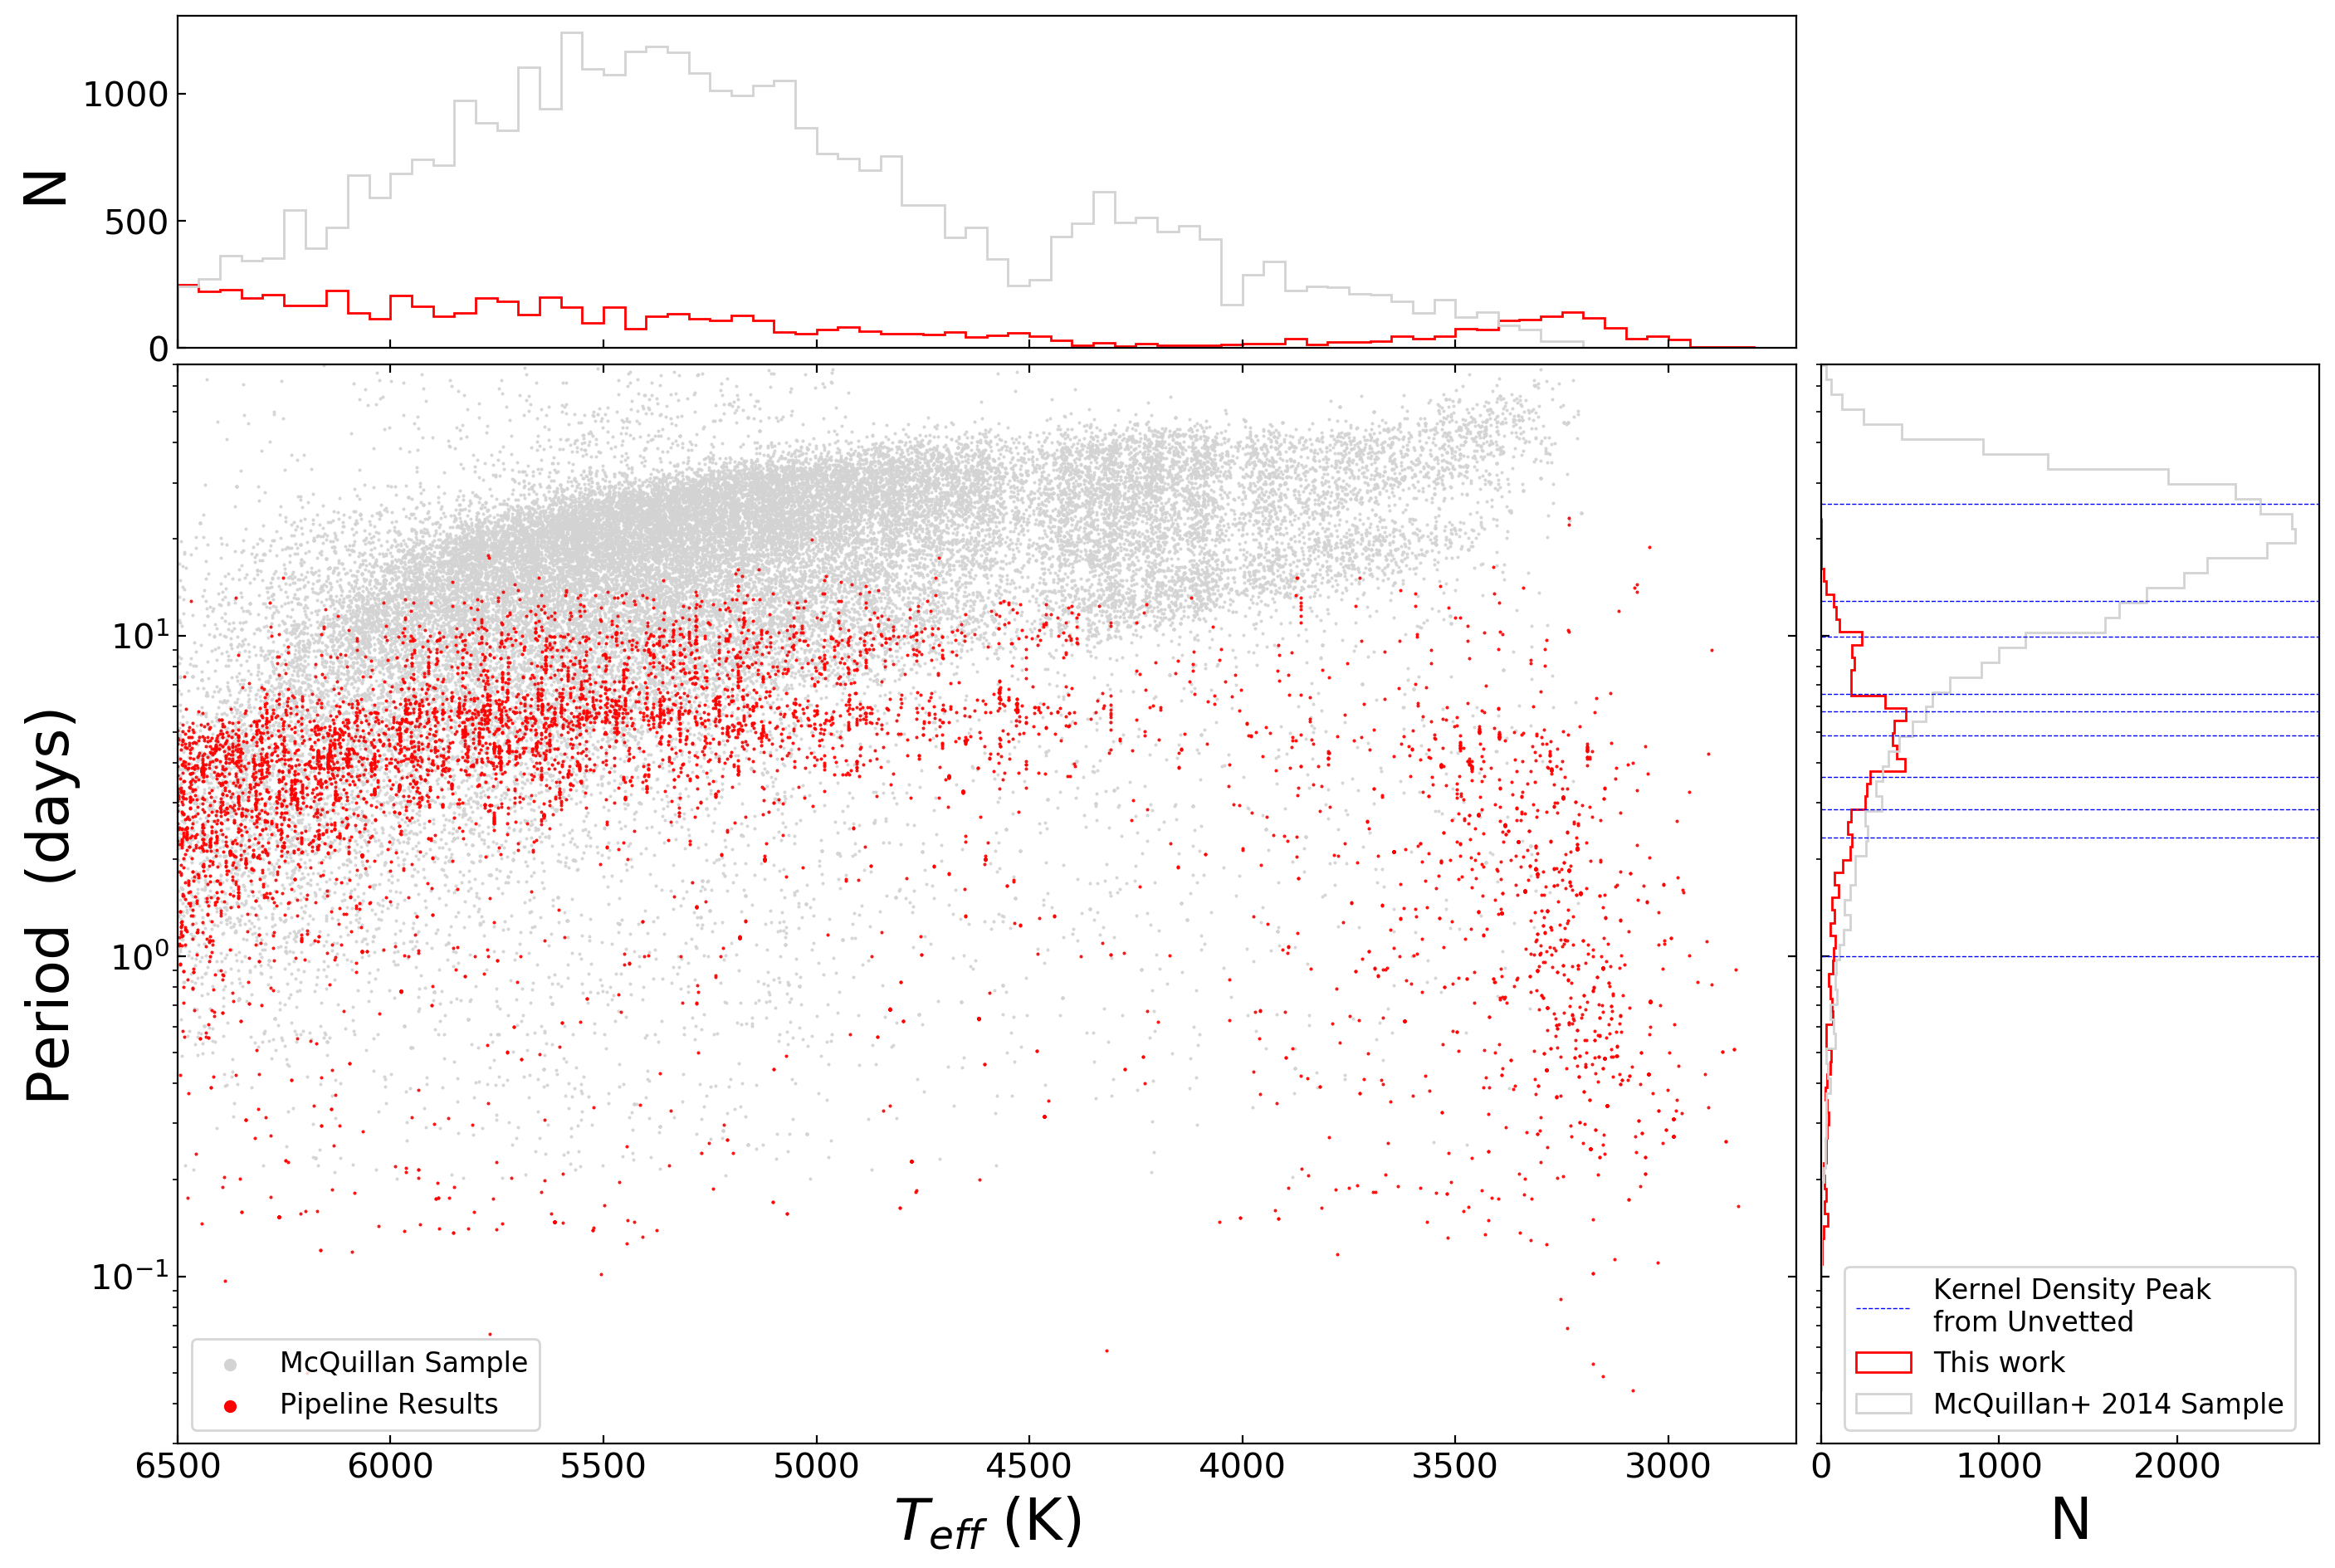

In [6]:
#final plot vetted results with unvetted systematics

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01 #.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
# start with a rectangular Figure & format subplots using axes definitions
plt.figure(figsize=(15, 10),dpi=200)
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True, labelsize=15)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False, labelsize=15)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False, labelsize=15)


###plot systematics peaks from unvetted results
for i in goodpeaks:
    if i == goodpeaks[0]:
        ax_histy.axhline(i, linestyle='--',linewidth=.5,color='b',label='Kernel Density Peak \nfrom Unvetted')
    else:
        ax_histy.axhline(i, linestyle='--',linewidth=.5,color='b')

# the scatter plot:
ax_scatter.scatter(mqdata['TEMP'],mqdata['ROTATION_PERIOD'].to_numpy(),color='lightgrey',s=.2,rasterized=True,label='McQuillan Sample')
ax_scatter.scatter(x, y,s=.2, color='r',rasterized=True, label='Pipeline Results')
ax_scatter.set_xlabel('$T_{eff}$ (K)',fontsize=25)
ax_scatter.set_ylabel('Period  (days)',fontsize=25)
ax_scatter.legend(fontsize='large', markerscale=10)
ax_scatter.set_xlim(6500, 2700)
ax_scatter.set_ylim((0.03, 70))
ax_scatter.set_yscale('log');

# top histogram
binwidth = 0.25
xbins = np.arange(2700, 6500 + binwidth, 50)
ax_histx.hist(x, bins=xbins, histtype='step',color='r')
ax_histx.hist(mqdata['TEMP'], bins=xbins, histtype='step',color='lightgrey')
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histx.set_ylabel('N',fontsize=25)

#side histogram
ybins2 = np.logspace(start=np.log10(min(y)), stop=np.log10(max(y)), num=70)
ax_histy.hist(y, bins=ybins2, histtype='step',orientation='horizontal',color='r',label='This work')
ybins3 = np.logspace(start=np.log10(min(y)), stop=np.log10(max(mqdata['ROTATION_PERIOD'].to_numpy())), num=70)
ax_histy.hist(mqdata['ROTATION_PERIOD'].to_numpy(), bins=ybins3, histtype='step',orientation='horizontal',color='lightgrey',label='McQuillan+ 2014 Sample')
ax_histy.set_xlabel('N',fontsize=25)
ax_histy.legend(fontsize='large',markerscale=10,loc='lower center')
ax_histy.set_yscale('log')
ax_histy.set_ylim(ax_scatter.get_ylim());

 
# plt.savefig('/Volumes/Seagate-stars/Final_Run/Plots/Vetted_periodteff.png')



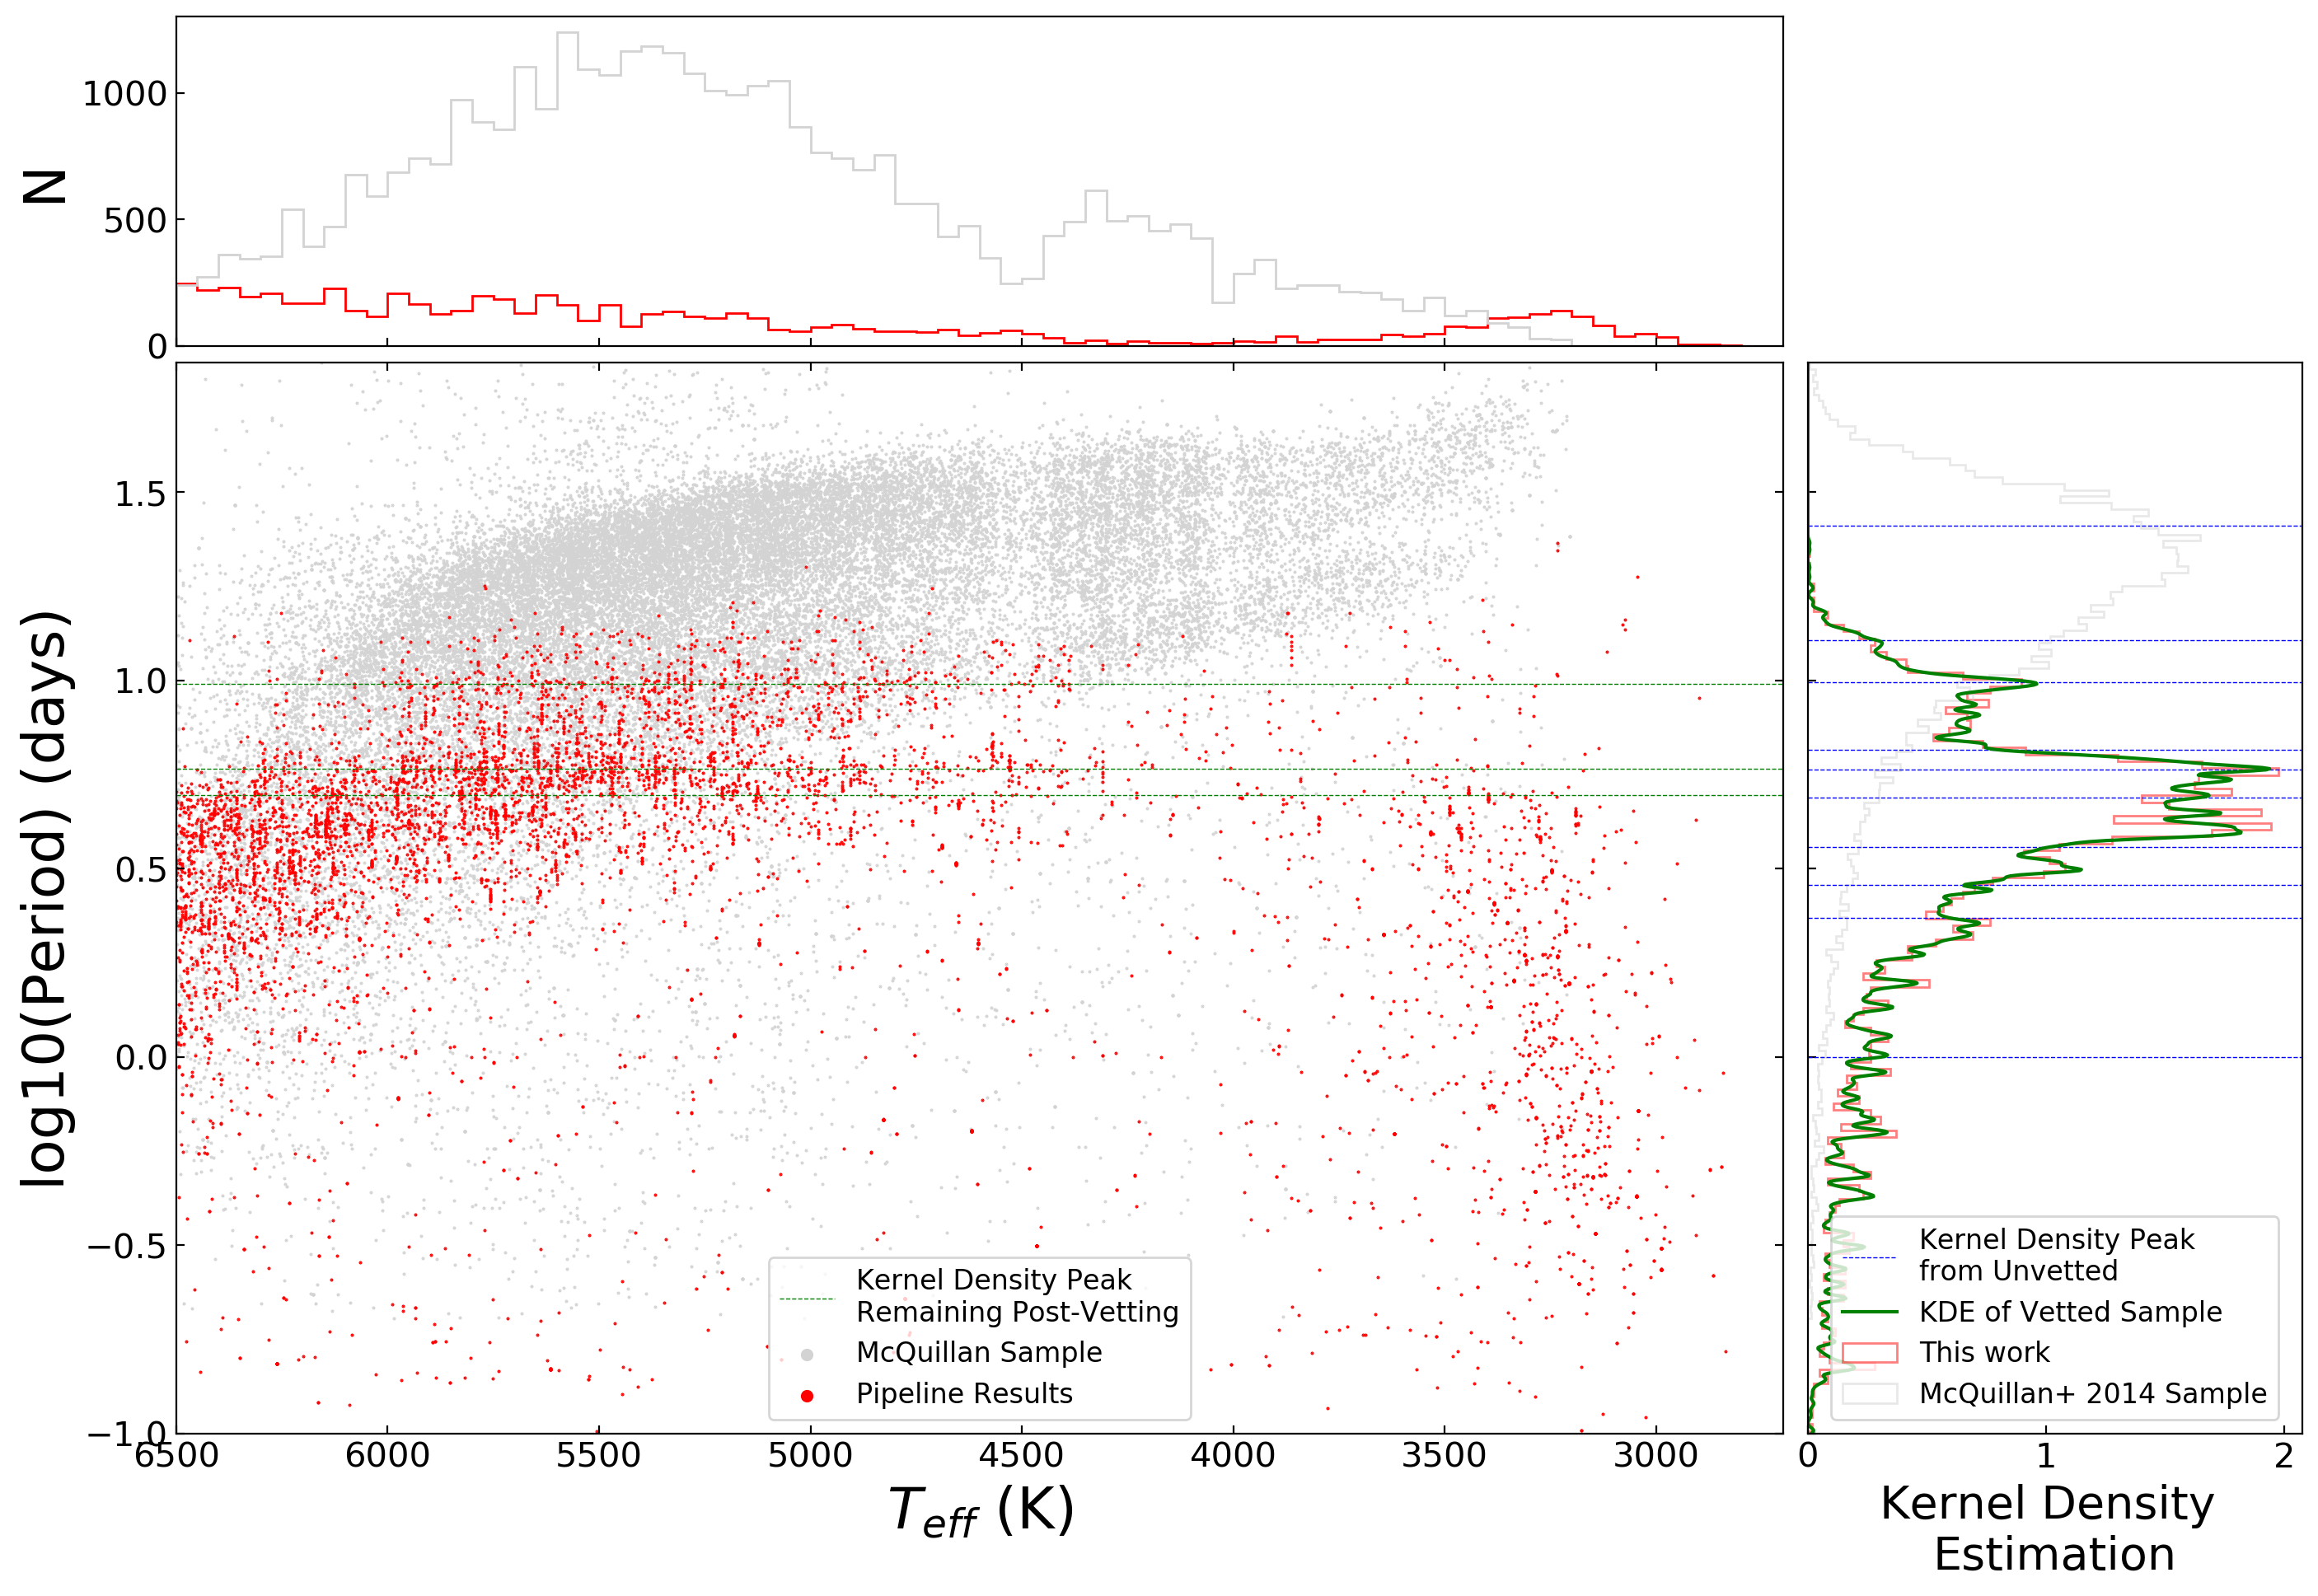

In [7]:
#final plot vetted results with unvetted systematics ~AND KDE OF VETTED SAMPLE~

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01 #.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
# start with a rectangular Figure & format subplots using axes definitions
plt.figure(figsize=(15, 10),dpi=200)
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True, labelsize=15)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False, labelsize=15)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False, labelsize=15)


###plot systematics peaks from unvetted results
for i in goodpeaks:
    if i == goodpeaks[0]:
        ax_histy.axhline(np.log10(i), linestyle='--',linewidth=.5,color='b',label='Kernel Density Peak \nfrom Unvetted')
    else:
        ax_histy.axhline(np.log10(i), linestyle='--',linewidth=.5,color='b')
###plot remaining systematics after vetting
# remaining_sys0 = goodpeaks[4:6] #grab 5th & 6th
# remaining_sys = np.concatenate((remaining_sys0,np.array([goodpeaks[7]]))) #grab 8th
kde_x2, kde_y2 = kde(np.log10(y), (np.log10(.1),np.log10(70)))
peaks2 = np.array([i for i in range(1, len(kde_y2)-1) if kde_y2[i-1] <
                  kde_y2[i] and kde_y2[i+1] < kde_y2[i]])
x_peaks2 = kde_x2[peaks2]
y_peaks2 = kde_y2[peaks2]
peaks3 = np.sort(10**(x_peaks2[x_peaks2>.001])) #set a threshold for peaks
remaining_sys0 = np.concatenate((np.array([peaks3[15]]), np.array([peaks3[17]]) ))
remaining_sys = np.concatenate((remaining_sys0,np.array([peaks3[22]])))
for i in remaining_sys:
    if i == remaining_sys[0]:
        ax_scatter.axhline(np.log10(i), linestyle='--',linewidth=.5,color='g',label='Kernel Density Peak \nRemaining Post-Vetting')
    else:
        ax_scatter.axhline(np.log10(i), linestyle='--',linewidth=.5,color='g')


# the scatter plot:
ax_scatter.scatter(mqdata['TEMP'],np.log10(mqdata['ROTATION_PERIOD'].to_numpy()),color='lightgrey',s=.2,rasterized=True,label='McQuillan Sample')
ax_scatter.scatter(x, np.log10(y),s=.2, color='r',rasterized=True, label='Pipeline Results')
ax_scatter.set_xlabel('$T_{eff}$ (K)',fontsize=25)
ax_scatter.set_ylabel('log10(Period) (days)',fontsize=25)
ax_scatter.legend(fontsize='large', markerscale=10)
ax_scatter.set_xlim(6500, 2700)
ax_scatter.set_ylim(np.log10(.1),np.log10(70));


# top histogram
binwidth = 0.25
xbins = np.arange(2700, 6500 + binwidth, 50)
ax_histx.hist(x, bins=xbins, histtype='step',color='r')
ax_histx.hist(mqdata['TEMP'], bins=xbins, histtype='step',color='lightgrey')
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histx.set_ylabel('N',fontsize=25)

#side histogram
ax_histy.hist(np.log10(y), bins=150, histtype='step',density=True,alpha=.5,orientation='horizontal',color='r',label='This work')
ax_histy.hist(np.log10(mqdata['ROTATION_PERIOD'].to_numpy()), bins=150, histtype='step',density=True,alpha=.5,orientation='horizontal',color='lightgrey',label='McQuillan+ 2014 Sample')
ax_histy.set_xlabel('Kernel Density \nEstimation',fontsize=20)
ax_histy.set_ylim(np.log10(.1),np.log10(70));
 

#side plot kde
ax_histy.plot(kde_y2, kde_x2,label='KDE of Vetted Sample',color='g');
ax_histy.legend(fontsize='large',markerscale=10,loc='lower center')



In [8]:
print('Unvetted KDE Peaks:',goodpeaks)
print('Vetted KDE Peaks:',peaks3)
print('\nUnvetted peaks close to vetted peaks:',remaining_sys)
print('Vetted peaks close to Unvetted peaks:',[peaks3[15], peaks3[17],peaks3[22]])

Unvetted KDE Peaks: [ 0.9991462   2.34348414  2.87176134  3.61265471  4.88463334  5.79266703
  6.56129462  9.91768102 12.80796198 25.83510614]
Vetted KDE Peaks: [ 1.01233659  1.13916848  1.35982338  1.5708594   1.72190251  1.87513205
  2.12394286  2.26789158  2.45356541  2.5857183   2.77912842  3.14789029
  3.27421553  3.96002291  4.45615949  4.9491186   5.46068408  5.83077806
  6.73567809  7.38333488  8.09326593  8.64178128  9.78845715 12.55845436
 15.08963307 16.11232225 17.66157309 18.85857368 20.00508296 22.21812943
 23.26178912]

Unvetted peaks close to vetted peaks: [4.9491186  5.83077806 9.78845715]
Vetted peaks close to Unvetted peaks: [4.9491186041120185, 5.830778064912265, 9.788457154948036]
